In [1]:
# Make sure figures appears inline and animations works
%matplotlib widget

In [2]:
__version__ = '0.1.0'

# import engine module
import sirf.Gadgetron as pMR

# import CIL functionality for visualisation and iterative reconstruction
from cil.utilities.jupyter import islicer
from cil.optimisation.algorithms import FISTA, PDHG
from cil.plugins.ccpi_regularisation.functions.regularisers import  RegulariserFunction
from cil.plugins.ccpi_regularisation.functions import  FGP_TV
from cil.optimisation.functions import LeastSquares, ZeroFunction, L2NormSquared

from cil.framework import  AcquisitionGeometry, BlockDataContainer, BlockGeometry, ImageGeometry, ImageData
from cil.optimisation.operators import GradientOperator, BlockOperator, ZeroOperator, CompositionOperator,LinearOperator

# import further modules
import os
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
# Trajectory for Golden angle radial acquisitions
def calc_rad_traj(ad):  
    dims = ad.dimensions()
    kx = np.linspace(-dims[2]//2, dims[2]//2, dims[2])
    ky = np.linspace(0, dims[0]-1, dims[0])
    
    # Check if angle is already specified:
    angRad = ky * (np.pi / 180) * (180 * 0.618034)

    # Normalise radial points between [-0.5 0.5]
    krad = kx
    krad = krad / (np.amax(np.abs(krad)) * 2)

    # Calculate trajectory
    rad_traj = np.zeros((dims[2], dims[0], 2), dtype=np.float32)
    rad_traj[:, :, 0] = krad.reshape(-1, 1) * np.cos(angRad)
    rad_traj[:, :, 1] = krad.reshape(-1, 1) * np.sin(angRad)
    rad_traj = np.moveaxis(rad_traj, 0, 1)    
    return(rad_traj)

In [4]:
pname = ''
fname = '2D_GRad_map_t1.h5'

In [5]:
# Load in the data
acq_data = pMR.AcquisitionData(pname + fname)
acq_data.sort_by_time()
acq_data = pMR.preprocess_acquisition_data(acq_data)

Started reading acquisitions from 2D_GRad_map_t1.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from 2D_GRad_map_t1.h5
Message received with ID: 5
Input stream has terminated


In [6]:
# Set trajectory
ktraj = calc_rad_traj(acq_data)
pMR.set_spiral2D_trajectory(acq_data, ktraj)

(1440, 256, 2)


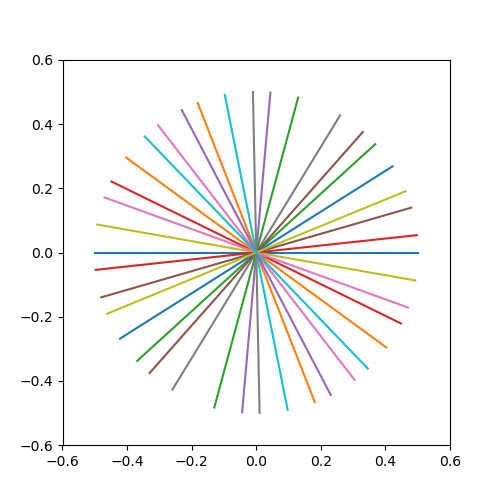

In [7]:
# Visualise trajectory
print(ktraj.shape)

plot_nrad = 20
fig, ax = plt.subplots(figsize=(5,5))
l, = ax.plot([],[], '.b')
ax.axis([-0.6, 0.6, -0.6, 0.6])
for ind in range(plot_nrad):
    plt.plot(ktraj[ind,:,0], ktraj[ind,:,1], '-');

In [8]:
# Calculate coil sensitivity maps
csm = pMR.CoilSensitivityData()
csm.smoothness = 100
csm.calculate(acq_data)

## Static reconstruction

In [9]:
# Create acquisition model
E = pMR.AcquisitionModel(acqs=acq_data, imgs=csm)
E.set_coil_sensitivity_maps(csm)

In [10]:
# Inverse
rec_im_inv = E.inverse(acq_data)
rec_im_inv_arr = rec_im_inv.as_array()

# Backward
rec_im_bck = E.backward(acq_data)
rec_im_bck_arr = rec_im_bck.as_array()

In [11]:
# We set up our AcquisitionModel
x_init = pMR.ImageData()
x_init.from_acquisition_data(acq_data)
E = pMR.AcquisitionModel(acqs=acq_data, imgs=x_init)
E.set_coil_sensitivity_maps(csm)

# Define our objective/loss function as least squares between Ex and y
f = LeastSquares(E, acq_data, c=1)

# Here we are not going to use any further regularisation, but if you want to change this, 
# using e.g. TV-regularisation you could change this to
# alpha = 0.00001
# G = alpha * FGP_TV(max_iteration=10, device='cpu')
# where alpha is the strenght of the regularisation
G = ZeroFunction()


# Set up FISTA
fista = FISTA(initial=x_init, f=f, g=G)
fista.max_iteration = 100
fista.update_objective_interval = 5


# Run FISTA for least squares
fista.run(40, verbose=True)
rec_fista_arr = fista.get_output().as_array()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          3.21517e-03
        5        100         0.971          1.46797e-03
       10        100         0.933          1.43427e-03
       15        100         0.939          1.43176e-03
       20        100         0.957          1.43077e-03
       25        100         0.975          1.43048e-03
       30        100         0.925          1.43032e-03
       35        100         0.889          1.43025e-03
       40        100         0.861          1.43021e-03
-------------------------------------------------------
       40        100         0.861          1.43021e-03
Stop criterion has been reached.



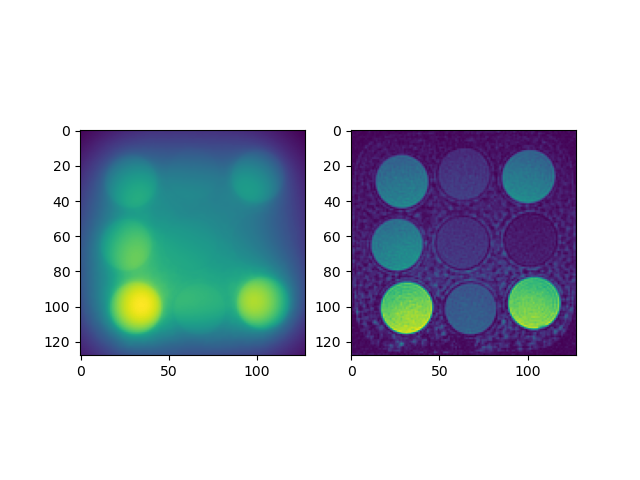

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(np.squeeze(rec_im_inv_arr)))
ax[1].imshow(np.abs(np.squeeze(rec_fista_arr)))

## Dynamic reconstruction

In [13]:
# Parameters for dynamics
ndyn = 4
nrad_per_dyn = 16

In [14]:
# Go through each dynamic, create corresponding k-space and acquisition model
acq_dyn = [0] * ndyn
E_dyn = [0] * ndyn
im_dyn_inv = [0] * ndyn

for ind in range(ndyn):
    acq_idx_dyn = np.linspace(ind*nrad_per_dyn, (ind+1)*nrad_per_dyn-1, nrad_per_dyn)
    acq_dyn[ind] = acq_data.get_subset(acq_idx_dyn) 
    acq_dyn[ind].sort_by_time()
        
    # Create acquisition model
    E_tmp = pMR.AcquisitionModel(acqs=acq_dyn[ind], imgs=csm)
    E_tmp.set_coil_sensitivity_maps(csm)
    im_dyn_inv[ind] = E_tmp.inverse(acq_dyn[ind])

    E_dyn[ind] = pMR.AcquisitionModel(acqs=acq_dyn[ind], imgs=im_dyn_inv[ind])
    E_dyn[ind].set_coil_sensitivity_maps(csm)
    
#E_dyn = E_dyn[::-1]
#acq_dyn = acq_dyn[::-1]

In [15]:
im_fista_dyn = [0] * ndyn
for ind in range(ndyn):

    # Starting image
    x_init = im_dyn_inv[ind].clone()
    x_init.fill(0.0)

    # Objective function
    f = LeastSquares(E_dyn[ind], acq_dyn[ind], c=1)
    G = ZeroFunction()

    # Set up FISTA for least squares
    fista = FISTA(initial=x_init, f=f, g=G)
    fista.max_iteration = 100
    fista.update_objective_interval = 5

    # Run FISTA
    fista.run(10, verbose=True)
    
    # Get result
    im_fista_dyn[ind] = fista.get_output()
    

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          6.99479e-05
        5        100         0.120          5.26654e-06
       10        100         0.122          4.46443e-06
-------------------------------------------------------
       10        100         0.122          4.46443e-06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          3.62965e-05
        5        100         0.119          2.79740e-06
       10        100         0.120          2.36295e-06
-------------------------------------------------------
       10        100         0.120          2.36295e-06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000  

In [16]:
im_pdhg_dyn = [0] * ndyn
for ind in range(ndyn):

    # Starting image
    x_init = im_dyn_inv[ind].clone()
    x_init.fill(0.0)

    fl2 = L2NormSquared(b=acq_dyn[ind])
    G = ZeroFunction()
    pdhg = PDHG(f=fl2, g=G, operator=E_dyn[ind], 
                max_iteration=10, update_objective_interval=1, initial=x_init)

    # Run PDHG
    pdhg.run(verbose=True)

    # Get result
    im_pdhg_dyn[ind] = pdhg.get_output()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          6.99479e-05
        1         10         0.191          1.19991e-05
        2         10         0.185          7.29871e-06
        3         10         0.188          5.71980e-06
        4         10         0.189          5.18540e-06
        5         10         0.187          4.90850e-06
        6         10         0.188          4.71084e-06
        7         10         0.187          4.60558e-06
        8         10         0.190          4.57301e-06
        9         10         0.193          4.56639e-06
       10         10         0.192          4.55534e-06
-------------------------------------------------------
       10         10         0.192          4.55534e-06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0     

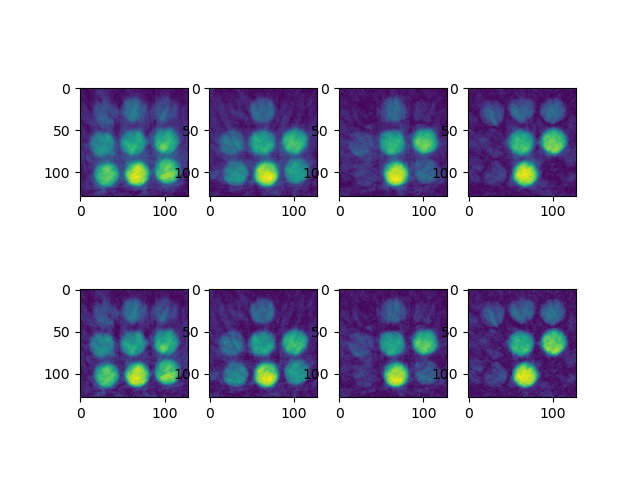

In [17]:
fig, ax = plt.subplots(2,ndyn)
for ind in range(ndyn):
    ax[0,ind].imshow(np.abs(np.squeeze(im_fista_dyn[ind].as_array())))
    ax[1,ind].imshow(np.abs(np.squeeze(im_pdhg_dyn[ind].as_array())))

In [18]:
# AcquisitionModel for each dynamic

# Create zero operator
ZOp = ZeroOperator(E_dyn[0].domain_geometry(), E_dyn[0].range_geometry())

E_dyn_diag = [ZOp,]*(ndyn*ndyn)
for ind in range(ndyn):
    E_dyn_diag[ind*ndyn+ind] = E_dyn[ind]
    
A = BlockOperator(*E_dyn_diag, shape=(ndyn, ndyn))

# Put together all the raw k-space data for each motion state in a BlockDataContainer
acq_dyn_block = BlockDataContainer(*acq_dyn)

# Starting image
x_init = A.adjoint(acq_dyn_block)

In [19]:
# Set up optimisation
x_init_zero = x_init.copy()
x_init_zero.fill(0.0)

# Objective function
f = LeastSquares(A, acq_dyn_block, c=1)
f.calculate_Lipschitz()
G = ZeroFunction()

# Set up FISTA for least squares
fista = FISTA(initial=x_init_zero, f=f, g=G)
fista.max_iteration = 10
fista.update_objective_interval = 10

# Run FISTA
fista.run(100, verbose=True)

# Get result
im_fista_dyn_block = fista.get_output()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          5.34432e-03
       10         10         1.189          1.38184e-05
-------------------------------------------------------
       11         10         1.178                     
Stop criterion has been reached.



In [20]:
print(f.L)
print(A.norm())

66.26327557704599
5.756008841942739


In [21]:
A.domain.allocate().dtype

(numpy.complex64, numpy.complex64, numpy.complex64, numpy.complex64)

In [22]:
#PDHG??
#print(fl2.convex_conjugate(A.adjoint(acq_dyn_block)))

In [23]:
# larger sigma leads to slower convergence, for sigma < 10, problem diverges
fl2 = L2NormSquared(b=acq_dyn_block)
pdhg = PDHG(f=fl2, g=G, operator=A, sigma=5.0,
            max_iteration=100, update_objective_interval=10, initial=x_init)

# Run PDHG
pdhg.run(verbose=2)

# Get result
im_pdhg_dyn_block = pdhg.get_output()

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        100         0.000    5.34432e-03 -0.00000e+00-0.00000e+00j5.34432e-03+0.00000e+00j
       10        100         1.771    8.31236e-04 -3.78713e+01-1.55243e+00j3.78721e+01+1.55243e+00j
       20        100         1.630    1.37066e-04 -1.43285e+01-6.02737e-01j1.43286e+01+6.02737e-01j
       30        100         1.540    3.43696e-05 -5.51816e+00-2.21786e-01j5.51820e+00+2.21786e-01j
       40        100         1.619    1.74973e-05 -2.26943e+00-7.94511e-02j2.26945e+00+7.94511e-02j
       50        100         1.632    1.41278e-05 -1.10872e+00-4.07192e-02j1.10873e+00+4.07192e-02j
       60        100         1.662    1.34665e-05 -7.11634e-01-1.58943e-02j7.11647e-01+1.58943e-02j
       70        100         1.615    1.37048e-05 -5.66443e-01-4.36285e-03j5.66457e-01+4.36285e-03j
       80        100         1.583    1.44

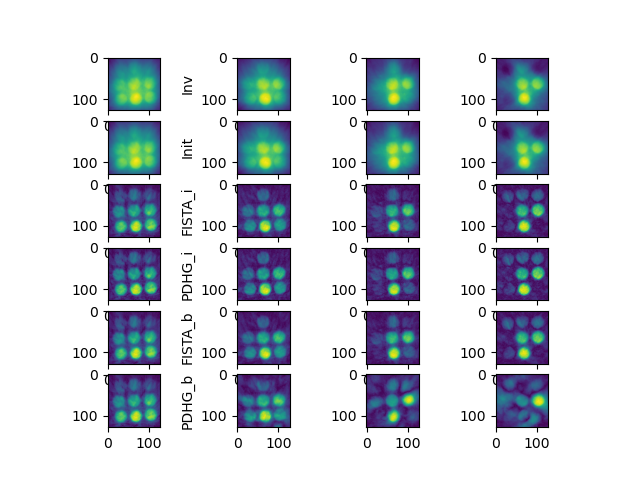

In [24]:
fig, ax = plt.subplots(6,ndyn)
for ind in range(ndyn):
    ax[0,ind].imshow(np.abs(np.squeeze(im_dyn_inv[ind].as_array())))
    ax[1,ind].imshow(np.abs(np.squeeze(x_init[ind].as_array())))
    ax[2,ind].imshow(np.abs(np.squeeze(im_fista_dyn[ind].as_array())))
    ax[3,ind].imshow(np.abs(np.squeeze(im_pdhg_dyn[ind].as_array())))
    ax[4,ind].imshow(np.abs(np.squeeze(im_fista_dyn_block[ind].as_array())))
    ax[5,ind].imshow(np.abs(np.squeeze(im_pdhg_dyn_block[ind].as_array())))
    
    if ind == 1:
        ax[0,ind].set_ylabel('Inv')
        ax[1,ind].set_ylabel('Init')
        ax[2,ind].set_ylabel('FISTA_i')
        ax[3,ind].set_ylabel('PDHG_i')
        ax[4,ind].set_ylabel('FISTA_b')
        ax[5,ind].set_ylabel('PDHG_b')

In [25]:
f_pc_block = fl2.proximal_conjugate(acq_dyn_block, 0.1)

fl2_single = L2NormSquared(b=acq_dyn[1])
f_pc_single = fl2_single.proximal_conjugate(acq_dyn_block[1], 0.1)

In [26]:
print((f_pc_block[0] - f_pc_single).as_array())

[[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]

 ...

 [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0

In [27]:
np.where((f_pc_block[0] - f_pc_single).as_array() > 0.0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))